<a href="https://colab.research.google.com/github/fabiobento/dnn-course-2024-1/blob/main/00_course_folder/cert_prof_time_series/time_series_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[adaptado do tutorial [_Time series forecasting_](https://www.coursera.org/professional-certificates/tensorflow-in-practice) de [_Tensorflow Core Tutorials_](https://www.tensorflow.org/tutorials)]

# Previsão de séries temporais

Este tutorial é uma introdução à previsão de séries temporais.

Serão utilizados diferentes tipos de modelos, incluindo Redes Neurais Convolucionais e Recorrentes (CNNs e RNNs).

O tema será abordado em duas partes principais, com subsecções:

* Previsão para um único passo de tempo:
  * Uma única caraterística.
  * Todas as características.
* Previsão de vários passos:
  Previsão para uma única etapa:
  * Uma única caraterística(_single-shot_): Faz as previsões de uma só vez.
  * Autoregressivo: Fazer uma previsão de cada vez e alimenta o modelo com o resultado.


## Configuração

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-04-05 11:46:25.996991: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 11:46:26.242285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 11:46:26.242325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 11:46:26.243414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 11:46:26.374173: I tensorflow/core/platform/cpu_feature_g

## Um conjunto de dados meteorológicos

Esse tutorial usa <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> registrado pelo <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

Este conjunto de dados contém 14 características diferentes, como a temperatura do ar, a pressão atmosférica e a humidade.
 Estes dados foram recolhidos a cada 10 minutos, com início em 2003. Para maior eficiência, utilizará apenas os dados recolhidos entre 2009 e 2016.

 Esta secção do conjunto de dados foi preparada por François Chollet para o seu livro  <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Este tutorial só vai lidar com **previsões horárias**, por isso começamos por subamostrar os dados de intervalos de 10 minutos para intervalos de uma hora:

In [3]:
df = pd.read_csv(csv_path)
# "Fatie" [start:stop:step], começando do índice 5 e pegando cada 6° registro.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Vamos dar uma olhadela aos dados. Aqui estão as primeiras linhas:

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Confira a evolução de algumas características ao longo do tempo:

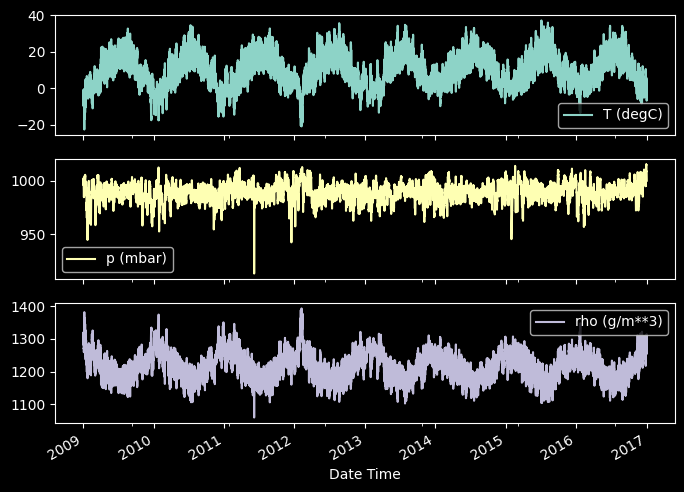

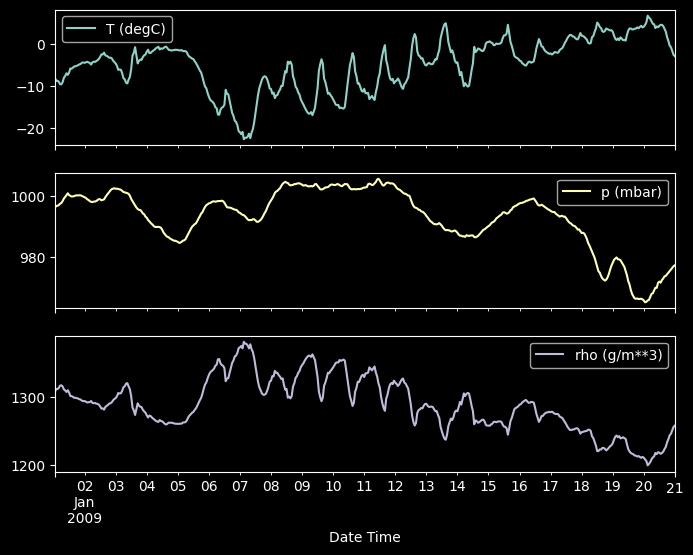

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspeção e limpeza

De seguida, veja as estatísticas do conjunto de dados:

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Velocidade do vento

Uma coisa que deve ser destacada é o valor `min` das colunas de velocidade do vento (`wv (m/s)`) e o valor máximo (`max. wv (m/s)`). Este `-9999` é provavelmente incorreto.

Existe uma coluna separada de direção do vento, por isso a velocidade deve ser maior que zero (`>=0`). Substitua-o por zeros:

In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Engenharia de recursos

Antes de começar a construir um modelo, é importante compreender os seus dados e certificar-se de que está transmitindo ao modelo dados formatados de forma adequada.

#### Vento
A última coluna dos dados, `wd (deg)`, indica a direção do vento em unidades de graus. Os ângulos não são boas entradas para o modelo: 360° e 0° devem estar próximos um do outro.

A direção não deve ter importância se o vento não estiver soprando.

Atualmente, a distribuição dos dados do vento tem este aspecto:

Text(0, 0.5, 'Velocidade do Vento [m/s]')

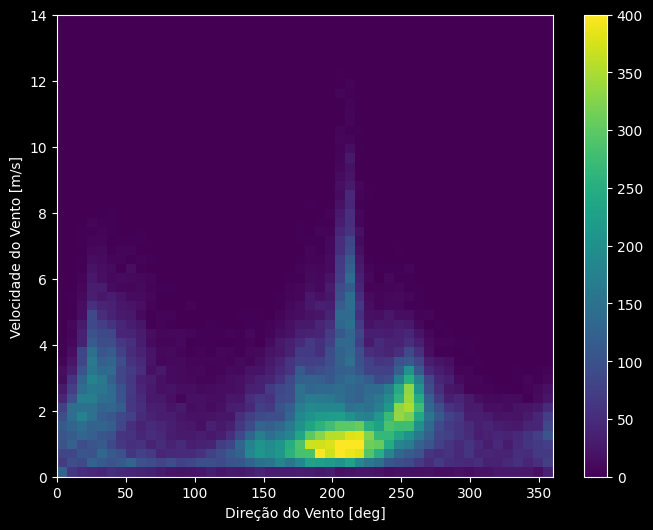

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Direção do Vento [deg]')
plt.ylabel('Velocidade do Vento [m/s]')

Mas será mais fácil para o modelo interpretar se você converter as colunas de direção e velocidade do vento em um **vetor** de vento:

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Converter para radianos.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calcular os componentes x e y do vento.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calcular os componentes máximo x e y do vento.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

A distribuição dos vetores de vento é muito mais simples de ser interpretada corretamente pelo modelo:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

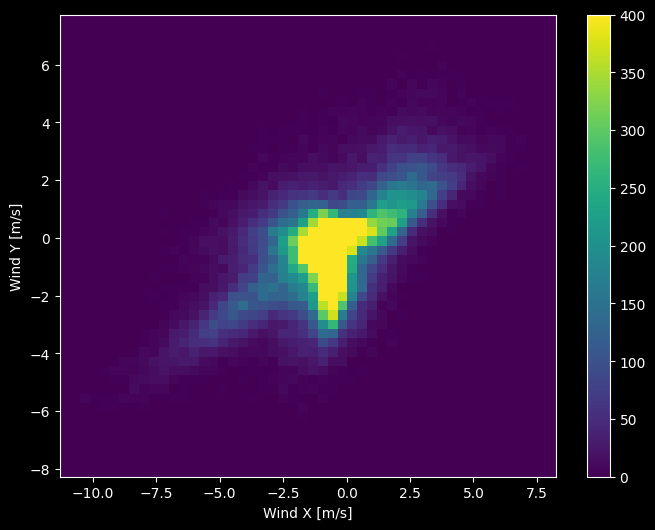

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Tempo

Da mesma forma, a coluna `Date Time` é muito útil, mas não nessa forma de string. Comece convertendo-a em segundos:

In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Da mesma forma que a direção do vento, o tempo em segundos não é uma entrada útil para o modelo.

Por serem dados meteorológicos, eles têm uma clara periodicidade diária e anual. Há muitas maneiras de lidar com a periodicidade.

Você pode obter sinais utilizáveis usando transformações de seno e cosseno para limpar os sinais de "_Time of day_" e "_Time of year_":

In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Sinal de hora do dia')

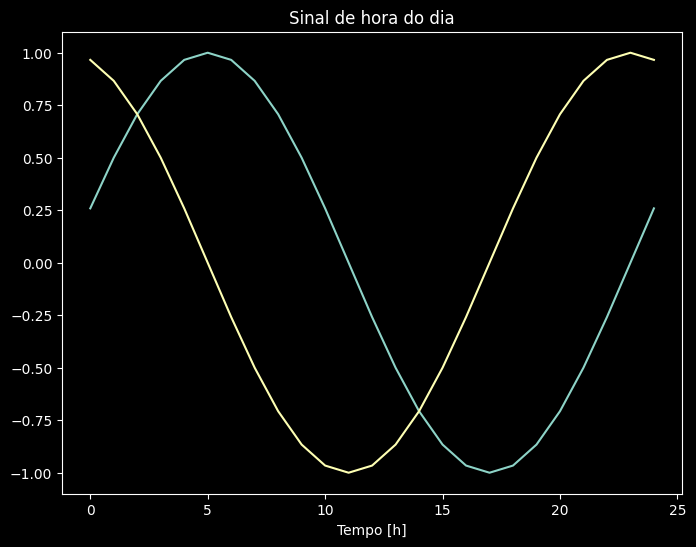

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Tempo [h]')
plt.title('Sinal de hora do dia')

Isso dá ao modelo acesso aos recursos de frequência mais importantes.

Nesse caso, você sabia antecipadamente quais frequências eram importantes.

Se você não tiver essas informações, poderá determinar quais frequências são importantes extraindo recursos com <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Transformada Rápida de Fourier(_Fast Fourier Transform_-FFT)</a>.

Para verificar as suposições, aqui está o `tf.signal.rfft` da temperatura ao longo do tempo. Observe os picos óbvios em frequências próximas a `1/ano` e `1/dia`:


2024-04-05 11:46:31.358610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 11:46:31.374981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-05 11:46:31.375206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

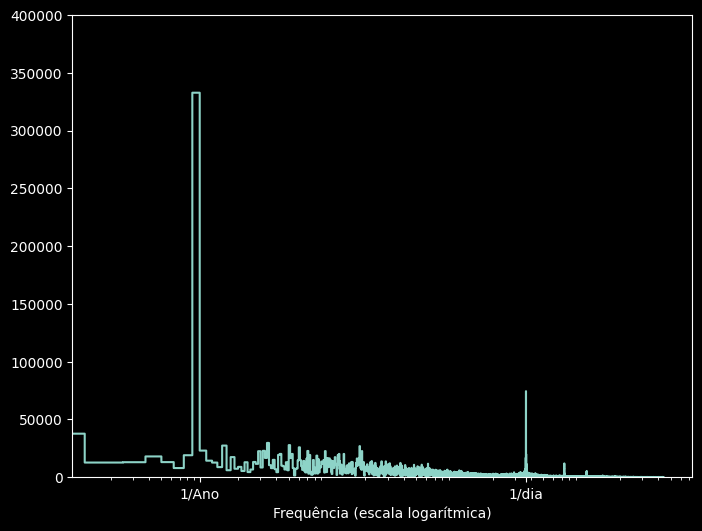

In [14]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Ano', '1/dia'])
_ = plt.xlabel('Frequência (escala logarítmica)')

### Dividir os dados

Você usará uma divisão `(70%, 20%, 10%)` para os conjuntos de treinamento, validação e teste.

Observe que os dados **não** estão sendo embaralhados aleatoriamente antes da divisão. Isso ocorre por dois motivos:

1. Ele garante que a divisão dos dados em janelas de amostras consecutivas ainda seja possível.
2. Garante que os resultados da validação/teste sejam mais realistas, sendo avaliados nos dados coletados depois que o modelo foi treinado.

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalizar os dados

É importante dimensionar os recursos antes de treinar uma rede neural. A normalização é uma forma comum de fazer esse dimensionamento: subtraia a média e divida pelo desvio padrão de cada recurso.

A média e o desvio padrão só devem ser calculados usando os dados de treinamento para que os modelos não tenham acesso aos valores nos conjuntos de validação e teste.

Também é possível argumentar que o modelo não deve ter acesso a valores futuros no conjunto de treinamento durante o treinamento e que essa normalização deve ser feita usando médias móveis.

Esse não é o foco deste tutorial, e os conjuntos de validação e teste garantem que você obtenha métricas (de certa forma) honestas. Portanto, para simplificar, utilizaremos nesse tutorial usa uma média simples.

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Agora, dê uma olhada na distribuição dos recursos. Alguns recursos têm caudas longas, mas não há erros óbvios como o valor `-9999` da velocidade do vento.

/tmp/ipykernel_575/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


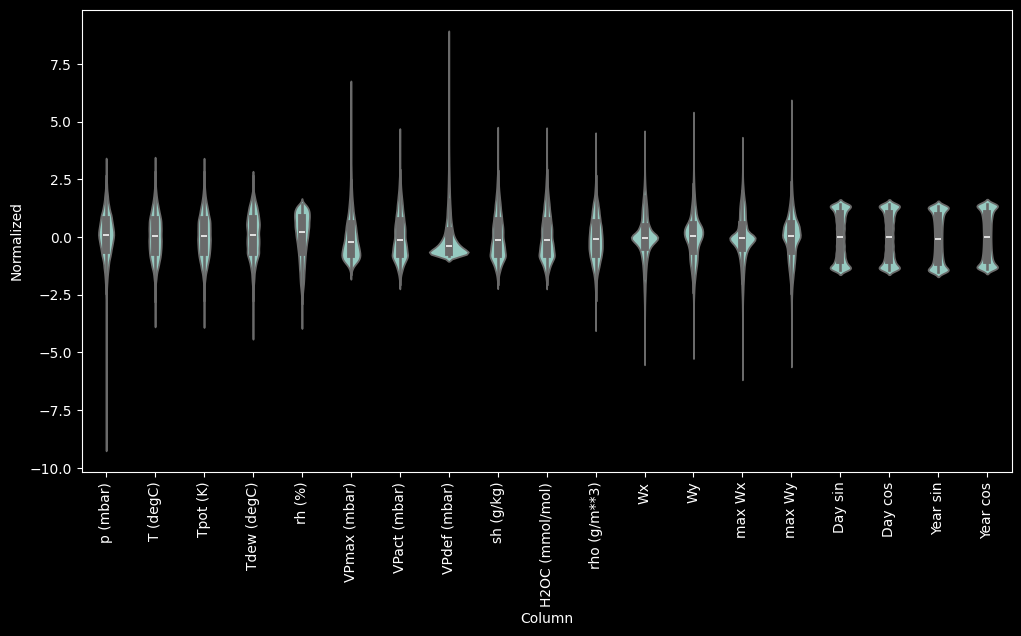

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Janelamento de dados

Os modelos deste tutorial farão um conjunto de previsões com base em uma janela de amostras consecutivas dos dados.

As principais características das janelas de entrada são:

- A largura (número de etapas de tempo) das janelas de entrada e de rótulo.
- O deslocamento de tempo entre elas.
- Quais recursos são usados como entradas, rótulos ou ambos.

Este tutorial cria uma variedade de modelos (incluindo modelos Linear, DNN, CNN e RNN) e os utiliza para ambos:

- Previsões de *single-output* e *multi-output*.
- Previsões *Single-time-step* e *multi-time-step*.

Esta seção se concentra na implementação do janelamento de dados para que ele possa ser reutilizado em todos esses modelos.


Dependendo da tarefa e do tipo de modelo, você pode querer gerar uma variedade de janelas de dados. Aqui estão alguns exemplos:

1. Por exemplo, para fazer uma única previsão de 24 horas no futuro, considerando 24 horas de histórico, você pode definir uma janela como esta:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. Um modelo que faz uma previsão de uma hora no futuro, considerando seis horas de histórico, precisaria de uma janela como esta:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

O restante desta seção define uma classe `WindowGenerator`. Essa classe pode:

1. Manipular os índices e deslocamentos conforme mostrado nos diagramas acima.
1. Dividir janelas de recursos em pares `(recursos, rótulos)`.
2. Plotar o conteúdo das janelas resultantes.
3. Gerar com eficiência lotes dessas janelas a partir dos dados de treinamento, avaliação e teste, usando `tf.data.Dataset`.

### 1. Índices e offsets

Comece criando a classe `WindowGenerator`. O método `__init__` inclui toda a lógica necessária para os índices de entrada e de rótulo.

Ele também recebe como entrada os DataFrames de treinamento, avaliação e teste. Eles serão convertidos em `tf.data.Dataset`s de janelas posteriormente.

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Armazene os dados brutos(raw data).
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Calcule os índices da coluna do rótulo.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Trabalhe com os parâmetros da janela.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Tamanho total da janela: {self.total_window_size}',
        f'Índices de entrada: {self.input_indices}',
        f'Índices dos rótulos: {self.label_indices}',
        f'Nome(s) da coluna de rótulos: {self.label_columns}'])

Aqui está o código para criar as duas janelas mostradas nos diagramas no início desta seção:

In [19]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Tamanho total da janela: 48
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Índices dos rótulos: [47]
Nome(s) da coluna de rótulos: ['T (degC)']

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Tamanho total da janela: 7
Índices de entrada: [0 1 2 3 4 5]
Índices dos rótulos: [6]
Nome(s) da coluna de rótulos: ['T (degC)']

### 2. Dividir

Dada uma lista de entradas consecutivas, o método `split_window` as converterá em uma janela de entradas e uma janela de rótulos.

O exemplo `w2` que você definiu anteriormente será dividido da seguinte forma:

![A janela inicial é composta por todas as amostras consecutivas, o que a divide em pares (inputs, labels)](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

Esse diagrama não mostra o eixo `features` dos dados, mas essa função `split_window` também manipula as `label_columns`, de modo que pode ser usada para os exemplos de saída única e saída múltipla.

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # O fatiamento não preserva as informações de estáticas de formato de dados, portanto, defina as formas
  # manualmente. Dessa forma, os `tf.data.Datasets` são mais fáceis de inspecionar.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Experimente:

In [22]:
# Empilhar três fatias, o comprimento da janela total.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('Todas os formatos são: (lote, tempo, recursos)')
print(f'Formado da janela: {example_window.shape}')
print(f'Formato das entradas: {example_inputs.shape}')
print(f'Formato das saídas: {example_labels.shape}')

Todas os formatos são: (lote, tempo, recursos)
Formado da janela: (3, 7, 19)
Formato das entradas: (3, 6, 19)
Formato das saídas: (3, 1, 1)


Normalmente, os dados no TensorFlow são empacotados em matrizes em que o índice mais externo é entre exemplos (a dimensão "lote"). Os índices intermediários são as dimensões de "tempo" ou "espaço" (largura, altura). Os índices mais internos são os recursos.

O código acima pegou um lote de três janelas de 7 etapas de tempo com 19 recursos em cada etapa de tempo. Ele as divide em um lote de entradas de 19 recursos em 6 etapas de tempo e um rótulo de 1 recurso em 1 etapa de tempo. O rótulo tem apenas um recurso porque o `WindowGenerator` foi inicializado com `label_columns=['T (degC)']`. Inicialmente, este tutorial criará modelos que preveem rótulos de saída única.

### 3. Plotagem

Aqui está um método de plotagem que permite uma visualização simples da janela dividida:

In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normalizado]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Entradas', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Rótulos', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predições',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Tempo [h]')

WindowGenerator.plot = plot

Esse gráfico alinha entradas, rótulos e (posteriormente) previsões com base no tempo a que o item se refere:

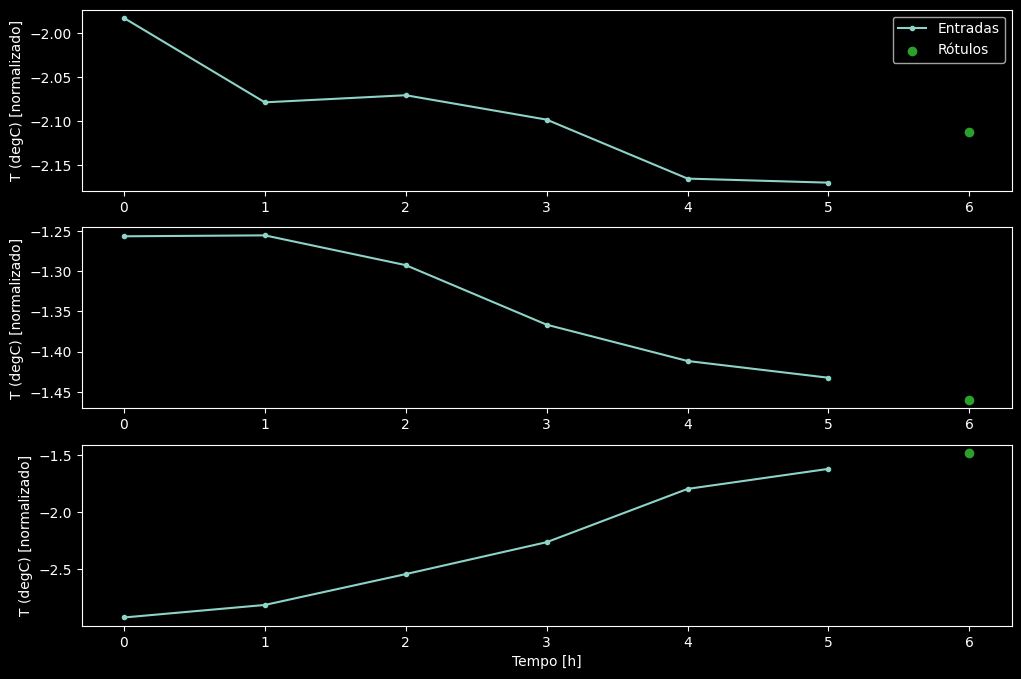

In [25]:
w2.plot()

Você pode plotar as outras colunas, mas a configuração da janela de exemplo `w2` só tem rótulos para a coluna `T (degC)`.

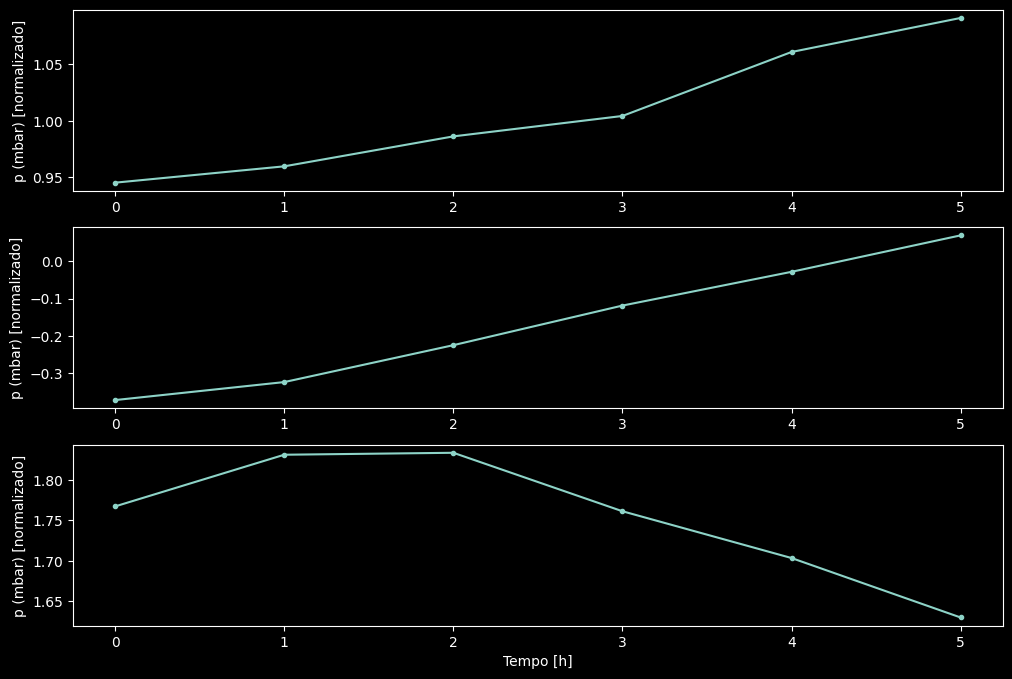

In [26]:
w2.plot(plot_col='p (mbar)')

### 4. Criar `tf.data.Dataset`s

Por fim, esse método `make_dataset` pegará um DataFrame de série temporal e o converterá em um `tf.data.Dataset` de pares `(input_window, label_window)` usando a função `tf.keras.utils.timeseries_dataset_from_array`:

In [27]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

O objeto `WindowGenerator` contém dados de treinamento, validação e teste.

Adicione propriedades para acessá-los como `tf.data.Dataset`s usando o método `make_dataset` que você definiu anteriormente. Além disso, adicione um lote de exemplo padrão para facilitar o acesso e a plotagem:

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Obtenha e armazene em cache um lote de exemplo de `inputs, labels` para plotagem."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Agora, o objeto `WindowGenerator` lhe dá acesso aos objetos `tf.data.Dataset`, para que você possa iterar facilmente sobre os dados.

A propriedade `Dataset.element_spec` informa a estrutura, os tipos de dados e as formas dos elementos do conjunto de dados.

In [29]:
# Cada elemento é um par (entradas, rótulo).
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

A iteração em um `Dataset` produz lotes concretos:

In [30]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Forma das entradas (lote, tempo, recursos): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Forma das entradas (lote, tempo, recursos): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Modelos de etapa única

O modelo mais simples que você pode criar com esse tipo de dados é aquele que prevê o valor de um único recurso em uma etapa de tempo (uma hora) no futuro com base apenas nas condições atuais.

Portanto, comece criando modelos para prever o valor `T (degC)` em uma hora no futuro.

![Prever o próximo passo de tempo](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure um objeto `WindowGenerator` para produzir esses pares `(input, label)` em uma única etapa:

In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Tamanho total da janela: 2
Índices de entrada: [0]
Índices dos rótulos: [1]
Nome(s) da coluna de rótulos: ['T (degC)']

O objeto `window` cria `tf.data.Dataset` a partir dos conjuntos de treinamento, validação e teste, permitindo que você itere facilmente sobre lotes de dados.

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Formato da entrada (lote, tempo, recursos): {example_inputs.shape}')
  print(f'Formato dos rótulos (lote, tempo, recursos): {example_labels.shape}')

Formato da entrada (lote, tempo, recursos): (32, 1, 19)
Formato dos rótulos (lote, tempo, recursos): (32, 1, 1)


### Linha de base

Antes de criar um modelo treinável, seria bom ter uma linha de base de desempenho como ponto de comparação com os modelos posteriores mais complicados.

Essa primeira tarefa é prever a temperatura em uma hora no futuro, considerando o valor atual de todos os recursos. Os valores atuais incluem a temperatura atual.

Portanto, comece com um modelo que retorne apenas a temperatura atual como previsão, prevendo "Nenhuma alteração". Essa é uma linha de base razoável, pois a temperatura muda lentamente. É claro que essa linha de base funcionará menos bem se você fizer uma previsão mais para o futuro.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instanciar e avaliar esse modelo:

In [34]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


Isso imprimiu algumas métricas de desempenho, mas elas não dão uma ideia de como o modelo está se saindo.

O `WindowGenerator` tem um método de plotagem, mas as plotagens não serão muito interessantes com apenas uma única amostra.

Portanto, crie um `WindowGenerator` mais amplo que gere janelas de 24 horas de entradas e rótulos consecutivos por vez.

A nova variável `wide_window` não altera a forma como o modelo opera. O modelo ainda faz previsões de uma hora no futuro com base em uma única etapa de tempo de entrada. Aqui, o eixo `time` atua como o eixo `batch`: cada previsão é feita de forma independente, sem interação entre as etapas de tempo:

In [35]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Tamanho total da janela: 25
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Índices dos rótulos: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Nome(s) da coluna de rótulos: ['T (degC)']

Essa janela expandida pode ser passada diretamente para o mesmo modelo de "linha de base" sem nenhuma alteração no código. Isso é possível porque as entradas e os rótulos têm o mesmo número de etapas de tempo, e a linha de base apenas encaminha a entrada para a saída:

![Uma previsão 1h no futuro, a cada hora.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [36]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Ao plotar as previsões do modelo de linha de base, observe que ele é simplesmente os rótulos deslocados para a direita em uma hora:

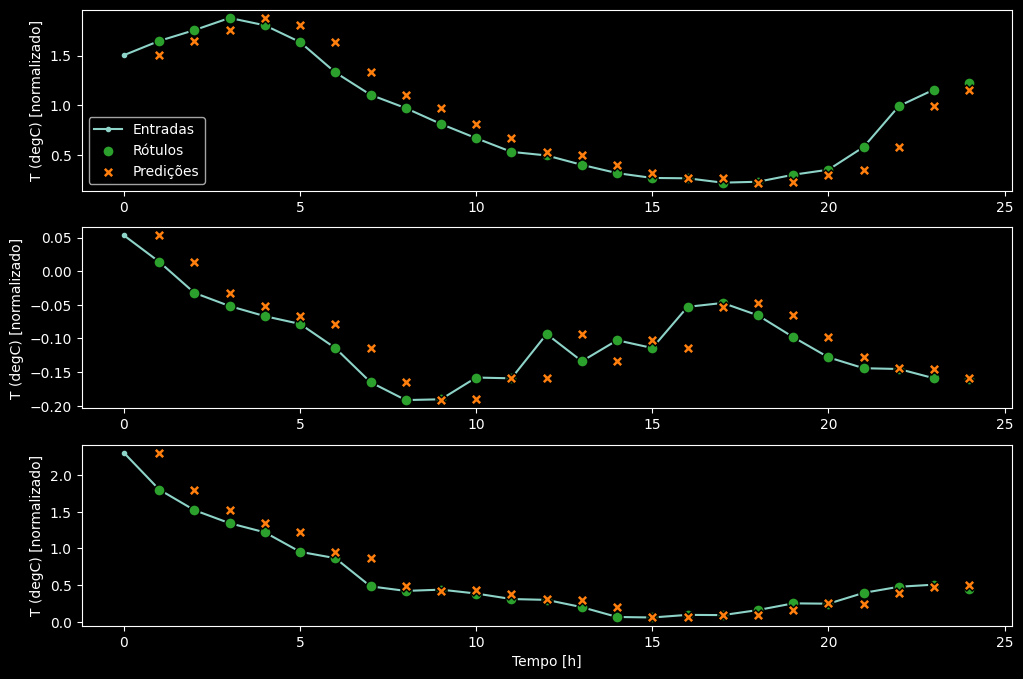

In [37]:
wide_window.plot(baseline)

Nos gráficos acima de três exemplos, o modelo de etapa única é executado ao longo de 24 horas. Isso merece alguma explicação:

- A linha azul `Inputs` mostra a temperatura de entrada em cada etapa de tempo. O modelo recebe todos os recursos, mas esse gráfico mostra apenas a temperatura.
- Os pontos verdes `Labels` mostram o valor de previsão desejado. Esses pontos são mostrados no momento da previsão, não no momento da entrada. É por isso que o intervalo de rótulos é deslocado 1 passo em relação às entradas.
- As cruzes `Predictions` em laranja são as previsões do modelo para cada etapa de tempo de saída. Se o modelo estivesse fazendo uma previsão perfeita, as previsões cairiam diretamente sobre os `Rótulos`.

### Modelo linear

O modelo **treinável** mais simples que você pode aplicar a essa tarefa é inserir uma transformação linear entre a entrada e a saída. Nesse caso, a saída de uma etapa de tempo depende apenas dessa etapa:

![Uma previsão de etapa única](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Uma camada `tf.keras.layers.Dense` sem conjunto de `ativação` é um modelo linear. A camada transforma apenas o último eixo dos dados de `(batch, time, inputs)` para `(batch, time, units)`; ela é aplicada independentemente a cada item nos eixos `batch` e `time`.

In [94]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [95]:
print('Formato de entrada:', single_step_window.example[0].shape)
print('Formato de saída:', linear(single_step_window.example[0]).shape)

Formato de entrada: (32, 1, 19)
Formato de saída: (32, 1, 1)


Este tutorial treina muitos modelos, portanto, empacote o procedimento de treinamento em uma função:

In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Treine o modelo e avalie seu desempenho:

In [41]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
   1/1534 [..............................] - ETA: 10:36 - loss: 2.3484 - mean_absolute_error: 1.1909

2024-04-05 11:46:38.496213: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x13044bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-05 11:46:38.496239: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-04-05 11:46:38.504515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-05 11:46:38.520821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-05 11:46:38.580653: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1534/1534 [==============================] - 3s 2ms/step - loss: 0.1741 - mean_absolute_error: 0.2608 - val_loss: 0.0175 - val_mean_absolute_error: 0.0986
Epoch 2/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0843 - val_loss: 0.0094 - val_mean_absolute_error: 0.0719
Epoch 3/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0716 - val_loss: 0.0089 - val_mean_absolute_error: 0.0701
Epoch 4/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 5/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0088 - val_mean_absolute_error: 0.0697
Epoch 6/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0088 - val_mean_absolute_error: 0.0697
Epoch 7/20
1534

Assim como o modelo `baseline`, o modelo linear pode ser chamado em lotes de janelas amplas. Usado dessa forma, o modelo faz um conjunto de previsões independentes em etapas de tempo consecutivas. O eixo `time` atua como outro eixo `batch`. Não há interações entre as previsões em cada etapa de tempo.

![Uma previsão de etapa única](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [42]:
print('Formato de entrada:', wide_window.example[0].shape)
print('Formato de saída:', linear(wide_window.example[0]).shape)

Formato de entrada: (32, 24, 19)
Formato de saída: (32, 24, 1)


Aqui está o gráfico de suas previsões de exemplo na `wide_window`; observe como, em muitos casos, a previsão é claramente melhor do que apenas retornar a temperatura de entrada, mas em alguns casos é pior:

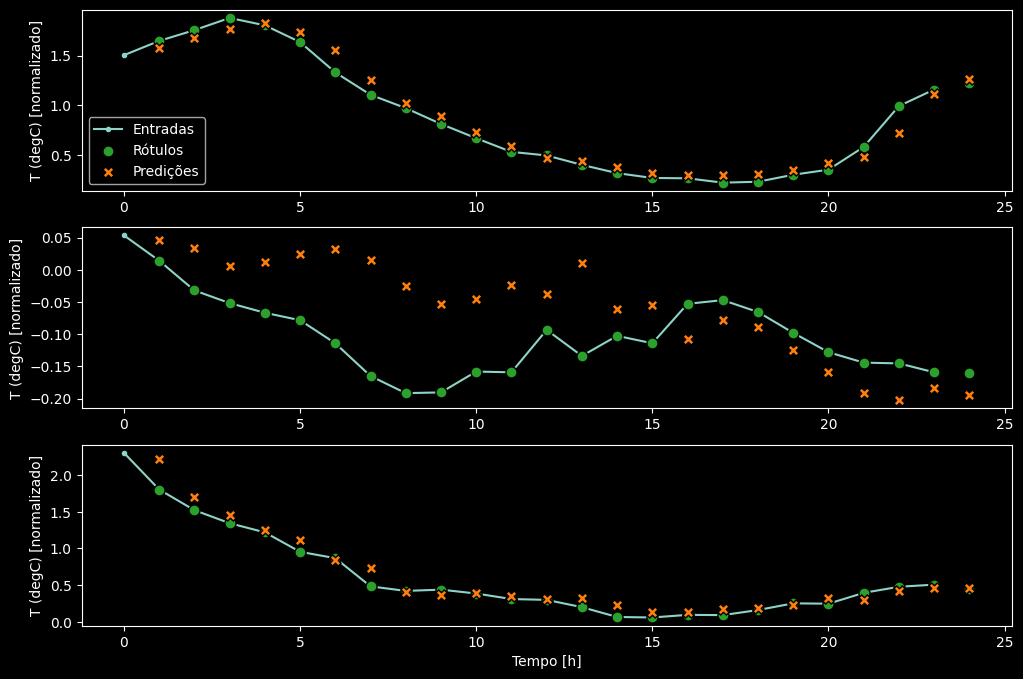

In [43]:
wide_window.plot(linear)

Uma vantagem dos modelos lineares é que eles são relativamente simples de interpretar.
Você pode extrair os pesos da camada e visualizar o peso atribuído a cada entrada:

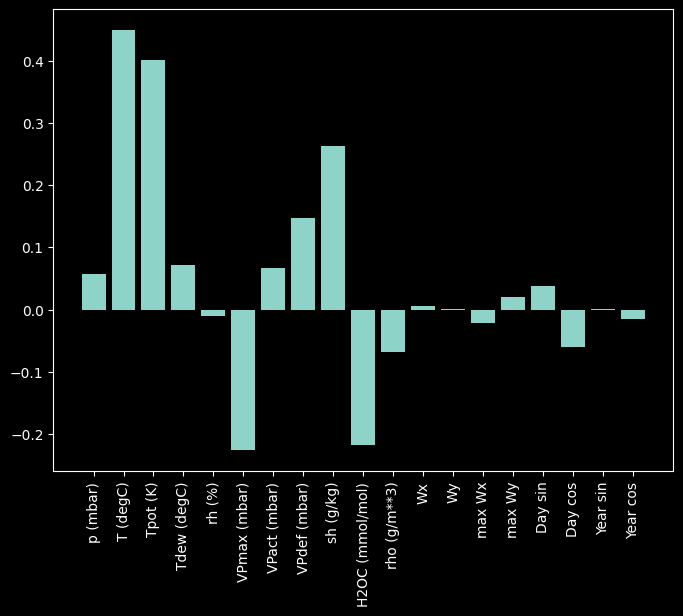

In [44]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Às vezes, o modelo nem mesmo atribui o maior peso à entrada `T (degC)`. Esse é um dos riscos da inicialização aleatória.

### Densa

Antes de aplicar modelos que realmente operam em várias etapas de tempo, vale a pena verificar o desempenho de modelos mais profundos e poderosos de etapa de entrada única.

Aqui está um modelo semelhante ao modelo `linear`, exceto pelo fato de que ele empilha várias camadas `Dense` entre a entrada e a saída:

In [45]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 [==============================] - 4s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0773 - val_loss: 0.0078 - val_mean_absolute_error: 0.0642
Epoch 2/20
1534/1534 [==============================] - 4s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0647 - val_loss: 0.0074 - val_mean_absolute_error: 0.0620
Epoch 3/20
1534/1534 [==============================] - 4s 2ms/step - loss: 0.0074 - mean_absolute_error: 0.0620 - val_loss: 0.0071 - val_mean_absolute_error: 0.0602
Epoch 4/20
1534/1534 [==============================] - 4s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0606 - val_loss: 0.0084 - val_mean_absolute_error: 0.0699
Epoch 5/20
439/439 [==============================] - 1s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0624


### Denso em várias etapas

Um modelo de etapa única não tem contexto para os valores atuais de suas entradas. Ele não consegue ver como os recursos de entrada estão mudando ao longo do tempo. Para resolver esse problema, o modelo precisa ter acesso a várias etapas de tempo ao fazer previsões:

![Três etapas de tempo são usadas para cada previsão.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


Os modelos `baseline`, `linear` e `dense` tratavam cada etapa de tempo de forma independente. Aqui, o modelo utilizará várias etapas de tempo como entrada para produzir uma única saída.

Crie um `WindowGenerator` que produzirá lotes de entradas de três horas e rótulos de uma hora:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [46]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Tamanho total da janela: 4
Índices de entrada: [0 1 2]
Índices dos rótulos: [3]
Nome(s) da coluna de rótulos: ['T (degC)']

Text(0.5, 0.98, 'Com 3 horas de dados, preveja 1 hora no futuro.')

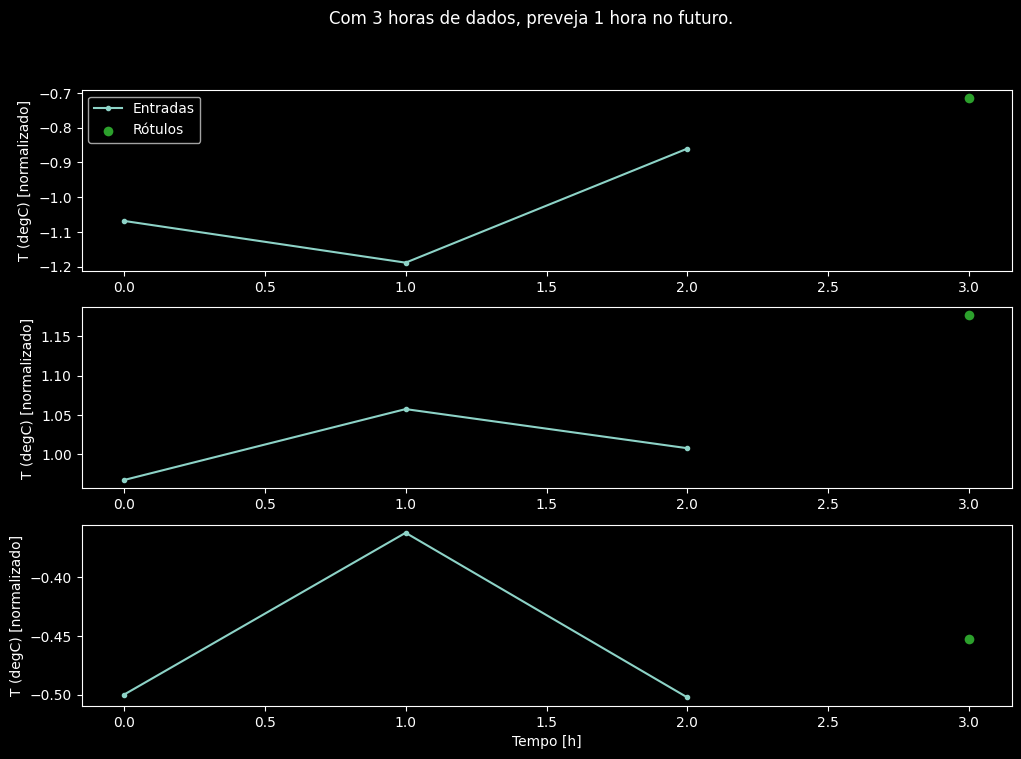

In [47]:
conv_window.plot()
plt.suptitle("Com 3 horas de dados, preveja 1 hora no futuro.")

Você poderia treinar um modelo `denso` em uma janela de várias etapas de entrada adicionando um `tf.keras.layers.Flatten` como a primeira camada do modelo:

In [48]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (tempo, recursos) => (tempo*recursos)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Adicione novamente a dimensão de tempo.
    # Formato: (saídas) => (1, saídas)
    tf.keras.layers.Reshape([1, -1]),
])

In [49]:
print('Formato da entrada:', conv_window.example[0].shape)
print('Formato da saída:', multi_step_dense(conv_window.example[0]).shape)

Formato da entrada: (32, 3, 19)
Formato da saída: (32, 1, 1)


In [50]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 [==============================] - 1s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0545


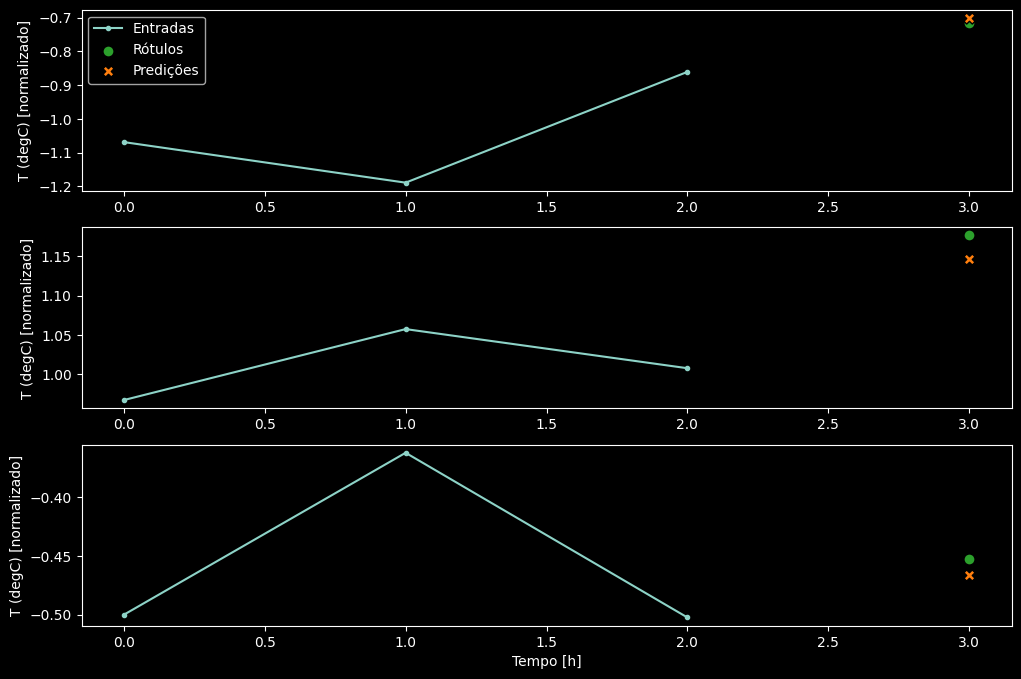

In [51]:
conv_window.plot(multi_step_dense)

O principal aspecto negativo dessa abordagem é que o modelo resultante só pode ser executado em janelas de entrada com exatamente esse formato.

In [52]:
print('Formato da entrada:', wide_window.example[0].shape)
try:
  print('Formato da saída:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Formato da entrada: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


Os modelos convolucionais da próxima seção resolvem esse problema.

### Rede neural de convolução

Uma camada de convolução (`tf.keras.layers.Conv1D`) também usa várias etapas de tempo como entrada para cada previsão.

Abaixo está o **mesmo** modelo do `multi_step_dense`, reescrito com uma convolução.

Observe as alterações:
* O `tf.keras.layers.Flatten` e o primeiro `tf.keras.layers.Dense` são substituídos por um `tf.keras.layers.Conv1D`.
* O `tf.keras.layers.Reshape` não é mais necessário, pois a convolução mantém o eixo do tempo em sua saída.

In [53]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Execute-o em um lote de exemplo para verificar se o modelo produz resultados com a forma esperada:

In [54]:
print("Modelo de conv em `conv_window`")
print('Formato da entrada:', conv_window.example[0].shape)
print('Formato da sída:', conv_model(conv_window.example[0]).shape)

Modelo de conv em `conv_window`
Formato da entrada: (32, 3, 19)
Formato da sída: (32, 1, 1)


Treine-o e avalie-o na `conv_window` e ele deverá apresentar desempenho semelhante ao do modelo `multi_step_dense`.

In [55]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 [==============================] - 1s 1ms/step - loss: 0.0067 - mean_absolute_error: 0.0589


A diferença entre esse modelo `conv_model` e o modelo `multi_step_dense` é que o `conv_model` pode ser executado em entradas de qualquer tamanho. A camada convolucional é aplicada a uma janela deslizante de entradas:

![Executando um modelo convolucional em uma sequência](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

Se você executá-lo em uma entrada mais ampla, ele produzirá uma saída mais ampla:

In [56]:
print("Janela ampla")
print('Formato da entrada:', wide_window.example[0].shape)
print('Formato de rótulos:', wide_window.example[1].shape)
print('Formato da saída:', conv_model(wide_window.example[0]).shape)

Janela ampla
Formato da entrada: (32, 24, 19)
Formato de rótulos: (32, 24, 1)
Formato da saída: (32, 22, 1)


Observe que a saída é mais curta que a entrada. Para que o treinamento ou a plotagem funcionem, você precisa que os rótulos e a previsão tenham o mesmo comprimento. Portanto, crie um `WindowGenerator` para produzir janelas amplas com algumas etapas extras de tempo de entrada para que os comprimentos do rótulo e da previsão coincidam:

In [57]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Tamanho total da janela: 27
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Índices dos rótulos: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Nome(s) da coluna de rótulos: ['T (degC)']

In [58]:
print("Convolução em janela ampla")
print('Formato de entrada:', wide_conv_window.example[0].shape)
print('Formato de rótulos:', wide_conv_window.example[1].shape)
print('Formato de saída:', conv_model(wide_conv_window.example[0]).shape)

Convolução em janela ampla
Formato de entrada: (32, 26, 19)
Formato de rótulos: (32, 24, 1)
Formato de saída: (32, 24, 1)


Agora, você pode plotar as previsões do modelo em uma janela mais ampla.

Observe as 3 etapas de tempo de entrada antes da primeira previsão. Cada previsão aqui é baseada nas 3 etapas de tempo anteriores:

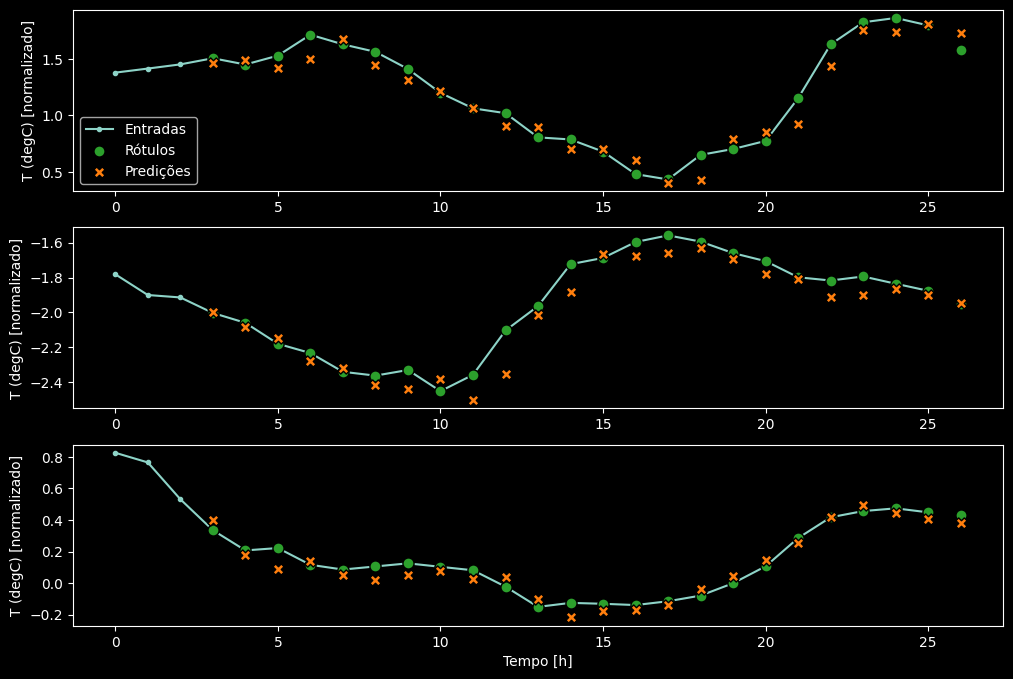

In [59]:
wide_conv_window.plot(conv_model)

### Rede neural recorrente

Uma Rede Neural Recorrente (RNN) é um tipo de rede neural adequada para dados de séries temporais. As RNNs processam uma série temporal passo a passo, mantendo um estado interno de etapa em etapa.

Para saber mais, consulte o tutorial [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) e o guia [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn).

Neste tutorial, você usará uma camada de RNN chamada Long Short-Term Memory (`tf.keras.layers.LSTM`).

Um argumento importante do construtor para todas as camadas RNN do Keras, como `tf.keras.layers.LSTM`, é o argumento `return_sequences`. Essa definição pode configurar a camada de duas maneiras:

1. Se for `False`, o padrão, a camada retornará apenas a saída da etapa de tempo final, dando ao modelo tempo para aquecer seu estado interno antes de fazer uma única previsão:

![Um LSTM aquecendo-se e fazendo uma única previsão](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. Se `True`, a camada retorna uma saída para cada entrada. Isso é útil para:
  * Empilhar camadas RNN.
  * Treinar um modelo em várias etapas de tempo simultaneamente.

![Um LSTM fazendo uma previsão após cada etapa de tempo](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [60]:
lstm_model = tf.keras.models.Sequential([
    # Formato [lote, tempo, recursos] => [lote, temp, unidades lstm]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Formato => [lote, tempo, recursos]
    tf.keras.layers.Dense(units=1)
])

Com `return_sequences=True`, o modelo pode ser treinado com 24 horas de dados por vez.

Observação: isso fornecerá uma visão pessimista do desempenho do modelo. Na primeira etapa de tempo, o modelo não tem acesso às etapas anteriores e, portanto, não pode se sair melhor do que os modelos `linear` e `dense` simples mostrados anteriormente.

In [61]:
print('Formato da entrada:', wide_window.example[0].shape)
print('Formato da saída:', lstm_model(wide_window.example[0]).shape)

Formato da entrada: (32, 24, 19)
Formato da saída: (32, 24, 1)


In [62]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 [==============================] - 1s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0520


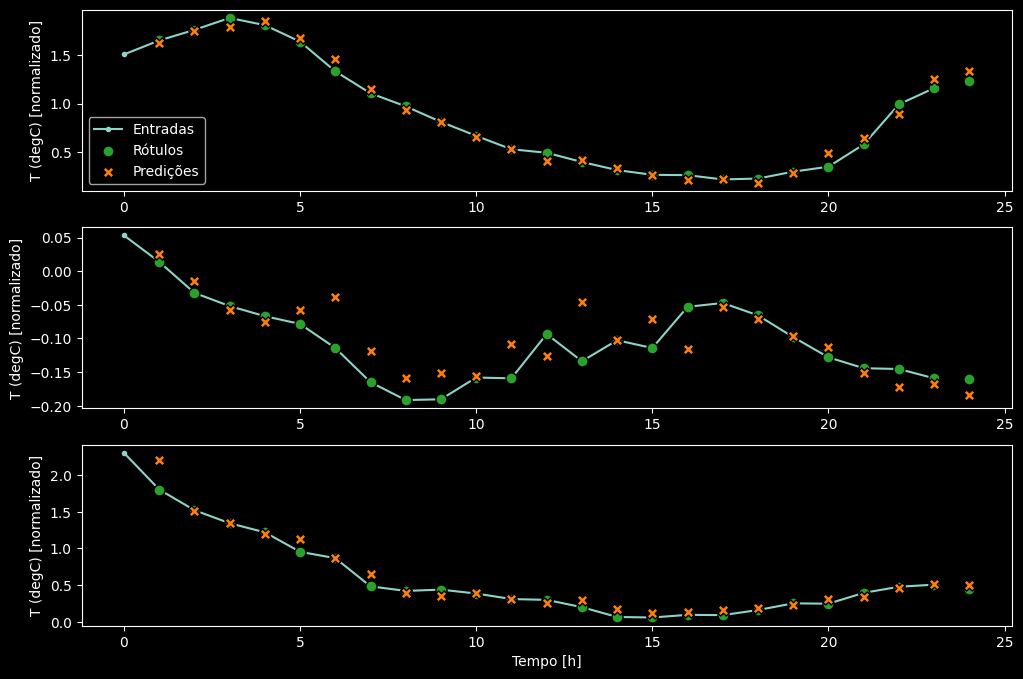

In [63]:
wide_window.plot(lstm_model)

### Performance

Com esse conjunto de dados, normalmente cada um dos modelos se sai um pouco melhor do que o anterior:

In [64]:
cm = lstm_model.metrics[1]
cm.metrics

[]

In [65]:
val_performance

{'Baseline': {'loss': 0.012845644727349281,
  'mean_absolute_error': 0.07846628129482269},
 'Linear': {'loss': 0.008763772435486317,
  'mean_absolute_error': 0.06984242796897888},
 'Dense': {'loss': 0.0072655756957829,
  'mean_absolute_error': 0.062387753278017044},
 'Multi step dense': {'loss': 0.00618530111387372,
  'mean_absolute_error': 0.054549138993024826},
 'Conv': {'loss': 0.006685485597699881,
  'mean_absolute_error': 0.058903131633996964},
 'LSTM': {'loss': 0.005658550187945366,
  'mean_absolute_error': 0.051973097026348114}}

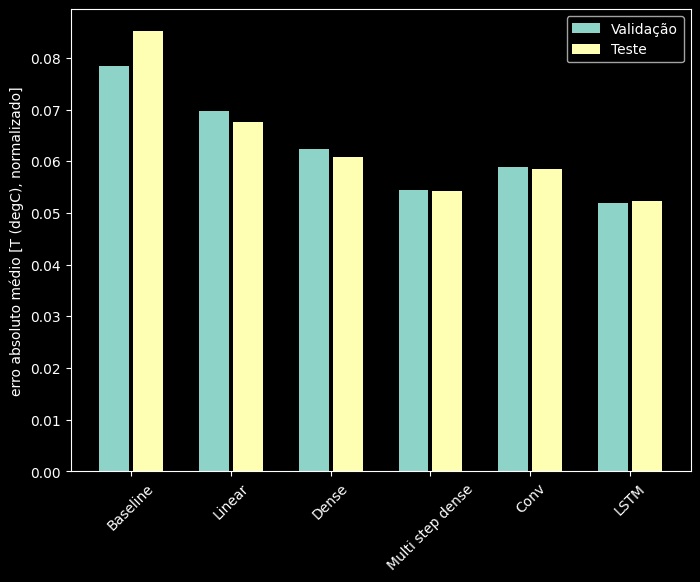

In [66]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('erro absoluto médio [T (degC), normalizado]')
plt.bar(x - 0.17, val_mae, width, label='Validação')
plt.bar(x + 0.17, test_mae, width, label='Teste')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [67]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0676
Dense       : 0.0609
Multi step dense: 0.0542
Conv        : 0.0586
LSTM        : 0.0524


### Modelos com várias saídas

Até agora, todos os modelos previram um único recurso de saída, `T (degC)`, para uma única etapa de tempo.

Todos esses modelos podem ser convertidos para prever vários recursos apenas alterando o número de unidades na camada de saída e ajustando as janelas de treinamento para incluir todos os recursos nos `labels` (`example_labels`):

In [68]:
single_step_window = WindowGenerator(
    # O `WindowGenerator` retorna todos os recursos como rótulos se você
    # não definir o argumento `label_columns`.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Formato de entrada (lote, tempo, recursos): {example_inputs.shape}')
  print(f'Formato de rótulos (lote, tempo, recursos): {example_labels.shape}')

Formato de entrada (lote, tempo, recursos): (32, 24, 19)
Formato de rótulos (lote, tempo, recursos): (32, 24, 19)


Observe acima que o eixo `features` dos rótulos agora tem a mesma profundidade que as entradas, em vez de `1`.

#### Baseline

O mesmo modelo de linha de base (`Baseline`) pode ser usado aqui, mas dessa vez repetindo todos os recursos em vez de selecionar um `label_index` específico:

In [69]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [70]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 [==============================] - 1s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [71]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [72]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

  1/439 [..............................] - ETA: 19s - loss: 0.0627 - mean_absolute_error: 0.1222

439/439 [==============================] - 1s 1ms/step - loss: 0.0672 - mean_absolute_error: 0.1285


#### RNN


In [73]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Formato [lote, tempo, recursos] => [lote, tempo, unidades lstm]
    tf.keras.layers.LSTM(32, return_sequences=True),
    #  Formato [lote, tempo, recursos
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()

  1/438 [..............................] - ETA: 16s - loss: 0.0546 - mean_absolute_error: 0.1116

438/438 [==============================] - 1s 2ms/step - loss: 0.0616 - mean_absolute_error: 0.1205

CPU times: user 2min 47s, sys: 20.8 s, total: 3min 8s
Wall time: 1min 20s


<a id="residual"></a>

#### Avançado: Conexões Residuais

O modelo `Baseline` de antes aproveitou o fato de que a sequência não muda drasticamente de uma etapa de tempo para outra. Todos os modelos treinados neste tutorial até agora foram inicializados aleatoriamente e, em seguida, tiveram de aprender que a saída é uma pequena alteração em relação à etapa de tempo anterior.

Embora você possa contornar esse problema com uma inicialização cuidadosa, é mais simples incorporar isso à estrutura do modelo.

É comum na análise de séries temporais criar modelos que, em vez de prever o próximo valor, prevejam como o valor mudará na próxima etapa de tempo. Da mesma forma,<a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or As ResNets - na aprendizagem profunda - referem-se a arquiteturas em que cada camada é adicionada ao resultado acumulado do modelo.

É assim que você tira proveito do conhecimento de que a mudança deve ser pequena.

![Um modelo com uma conexão residual](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essencialmente, isso inicializa o modelo para corresponder à `Baseline`. Para essa tarefa, ele ajuda os modelos a convergir mais rapidamente, com desempenho ligeiramente melhor.

Essa abordagem pode ser usada em conjunto com qualquer modelo discutido neste tutorial.

Aqui, ela está sendo aplicada ao modelo LSTM. Observe o uso de `tf.initializers.zeros` para garantir que as alterações iniciais previstas sejam pequenas e não dominem a conexão residual. Não há preocupações de quebra de simetria para os gradientes aqui, uma vez que os `zeros` são usados somente na última camada.

In [74]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # A previsão para cada etapa de tempo é a entrada
    # da etapa de tempo anterior mais o delta
    # calculado pelo modelo.
    return inputs + delta

In [75]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # Os deltas previstos devem começar pequenos.
        # Portanto, inicialize a camada de saída com zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

438/438 [==============================] - 1s 2ms/step - loss: 0.0619 - mean_absolute_error: 0.1178

CPU times: user 1min 8s, sys: 8.4 s, total: 1min 16s
Wall time: 32.7 s


#### Performance

Aqui está o desempenho geral desses modelos de várias saídas.

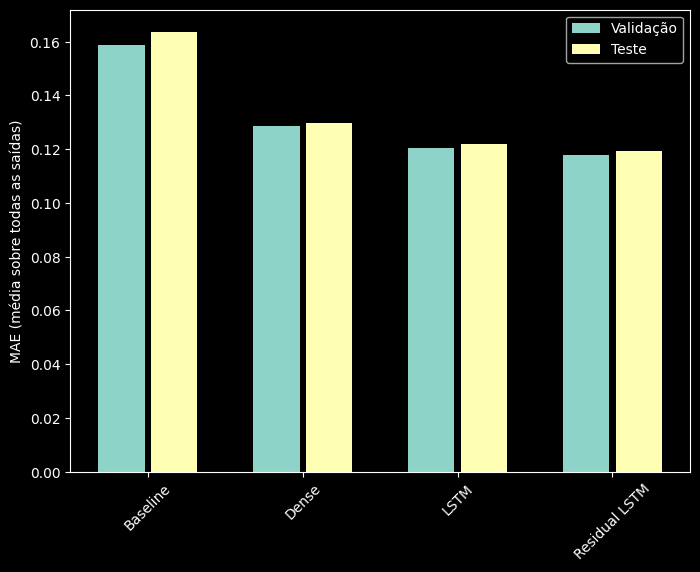

In [76]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validação')
plt.bar(x + 0.17, test_mae, width, label='Teste')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (média sobre todas as saídas)')
_ = plt.legend()

In [77]:
for name, value in performance.items():
  print(f'{name:15s}: {value[metric_name]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1299
LSTM           : 0.1220
Residual LSTM  : 0.1194


Os desempenhos acima são a média de todos os resultados do modelo.

## Modelos de várias etapas (_Multi-step models_)

Os modelos de saída única e de saída múltipla das seções anteriores fizeram **previsões de etapa única**, uma hora no futuro.

Esta seção analisa como expandir esses modelos para fazer **previsões de várias etapas**.

Em uma previsão de várias etapas, o modelo precisa aprender a prever um intervalo de valores futuros. Portanto, ao contrário de um modelo de etapa única, em que apenas um único ponto futuro é previsto, um modelo de várias etapas prevê uma sequência de valores futuros.

Há duas abordagens gerais para isso:

1. Previsões de uma única etapa, em que toda a série temporal é prevista de uma só vez.
2. Previsões autorregressivas em que o modelo faz apenas previsões de etapa única e sua saída é realimentada como entrada.

Nesta seção, todos os modelos farão a previsão de **todos os recursos em todas as etapas de tempo de saída**.


Para o modelo de várias etapas, os dados de treinamento consistem novamente em amostras horárias. Entretanto, aqui, os modelos aprenderão a prever 24 horas no futuro, considerando 24 horas do passado.

Aqui está um objeto `Window` que gera essas fatias do conjunto de dados:

Tamanho total da janela: 48
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Índices dos rótulos: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Nome(s) da coluna de rótulos: None

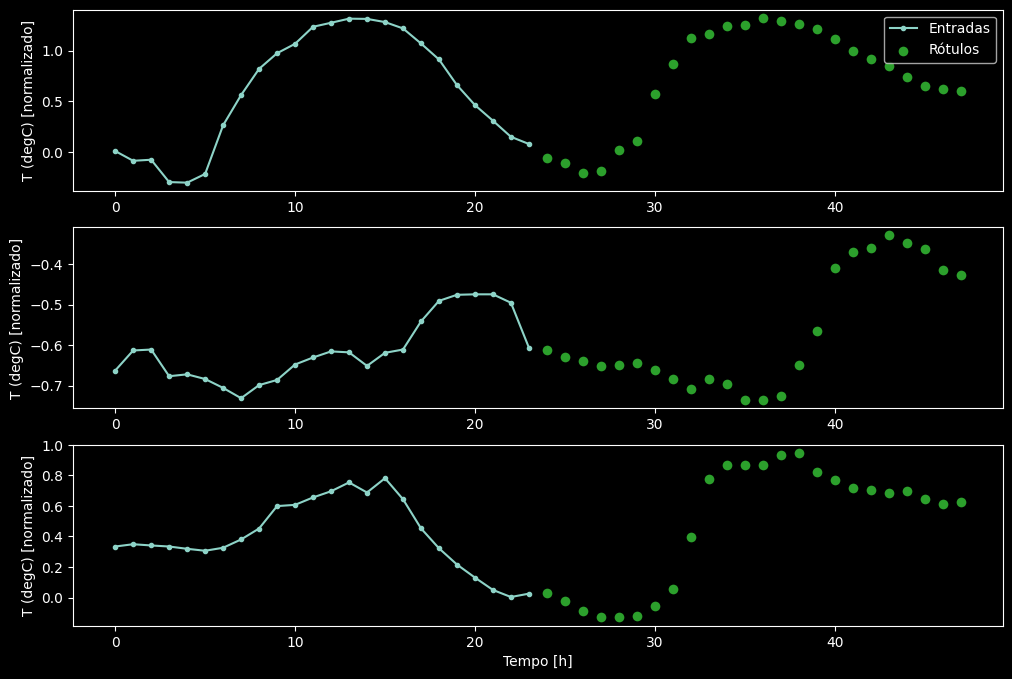

In [78]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

Uma linha de base simples para essa tarefa é repetir a última etapa de tempo de entrada para o número necessário de etapas de tempo de saída:

![Repetir a última entrada, para cada etapa de saída](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

437/437 [==============================] - 1s 1ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


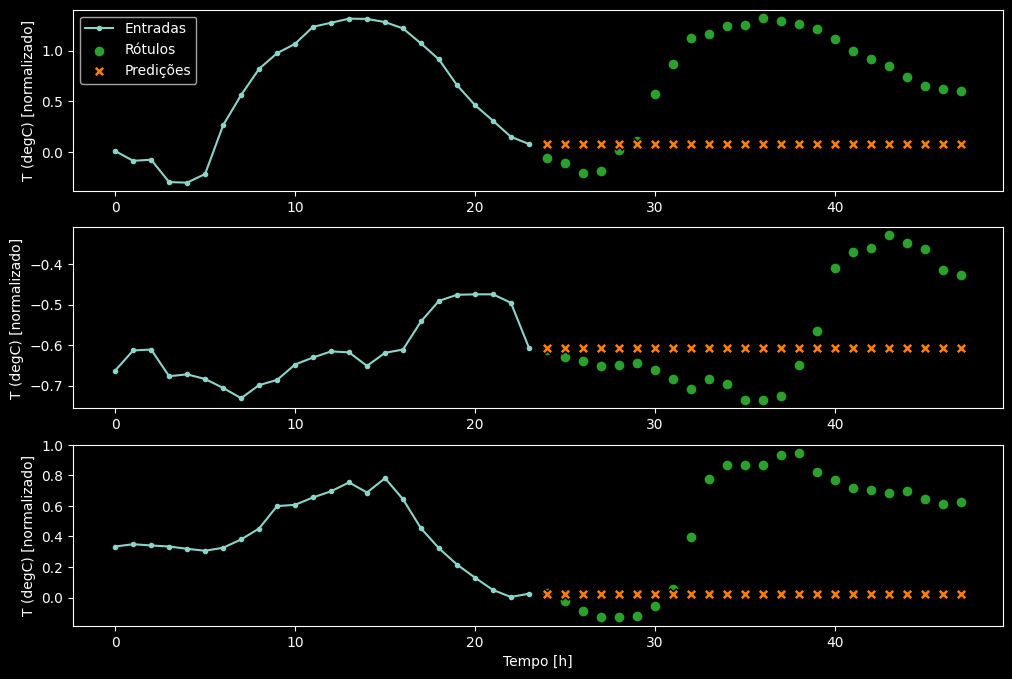

In [79]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

Como essa tarefa é prever 24 horas no futuro, considerando 24 horas do passado, outra abordagem simples é repetir o dia anterior, presumindo que amanhã será semelhante:

![Repetir o dia anterior](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

437/437 [==============================] - 1s 982us/step - loss: 0.4270 - mean_absolute_error: 0.3959


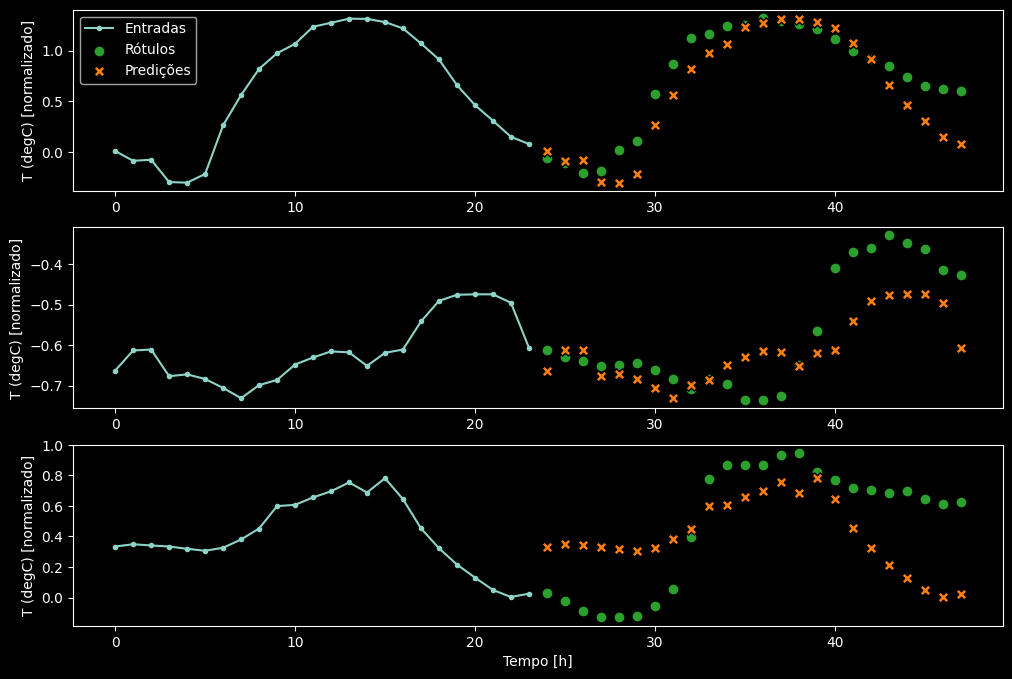

In [80]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

### Modelos de disparo único(_Single-shot_)

Uma abordagem de alto nível para esse problema é usar um modelo de "disparo único", em que o modelo faz a previsão de toda a sequência em uma única etapa.

Isso pode ser implementado de forma eficiente como um `tf.keras.layers.Dense` com unidades de saída `OUT_STEPS*features`. O modelo só precisa remodelar essa saída para o `(OUTPUT_STEPS, features)` necessário.

#### Linear

Um modelo linear simples baseado na última etapa de tempo de entrada é melhor do que qualquer uma das linhas de base, mas não tem potência suficiente. O modelo precisa prever as etapas de tempo `OUTPUT_STEPS` a partir de uma única etapa de tempo de entrada com uma projeção linear. Ele só pode capturar uma fatia de baixa dimensão do comportamento, provavelmente baseada principalmente na hora do dia e na época do ano.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

437/437 [==============================] - 1s 1ms/step - loss: 0.2552 - mean_absolute_error: 0.3048


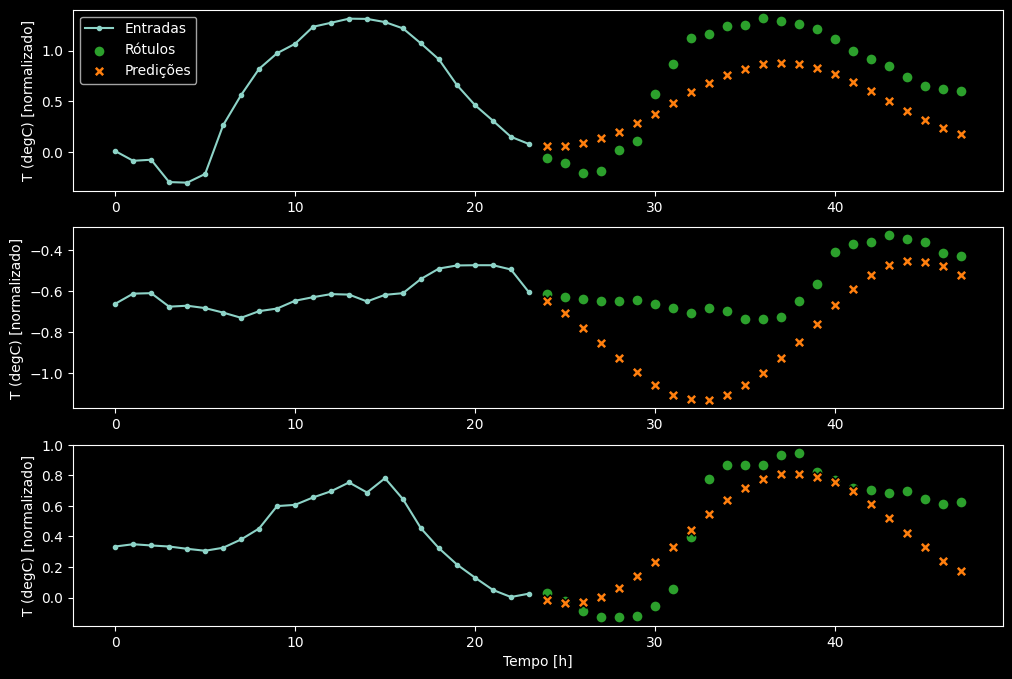

In [81]:
multi_linear_model = tf.keras.Sequential([
    # Pegue a última etapa de tempo.
    # Forma [lote, tempo, recursos] => [lote, 1, recursos]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Formato => [lote, 1, passos de saída*recursos]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Formato => [lote, passos de saída, recursos]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

#### Dense

A adição de um `tf.keras.layers.Dense` entre a entrada e a saída dá mais potência ao modelo linear, mas ainda se baseia apenas em uma única etapa de tempo de entrada.

437/437 [==============================] - 1s 1ms/step - loss: 0.2202 - mean_absolute_error: 0.2805


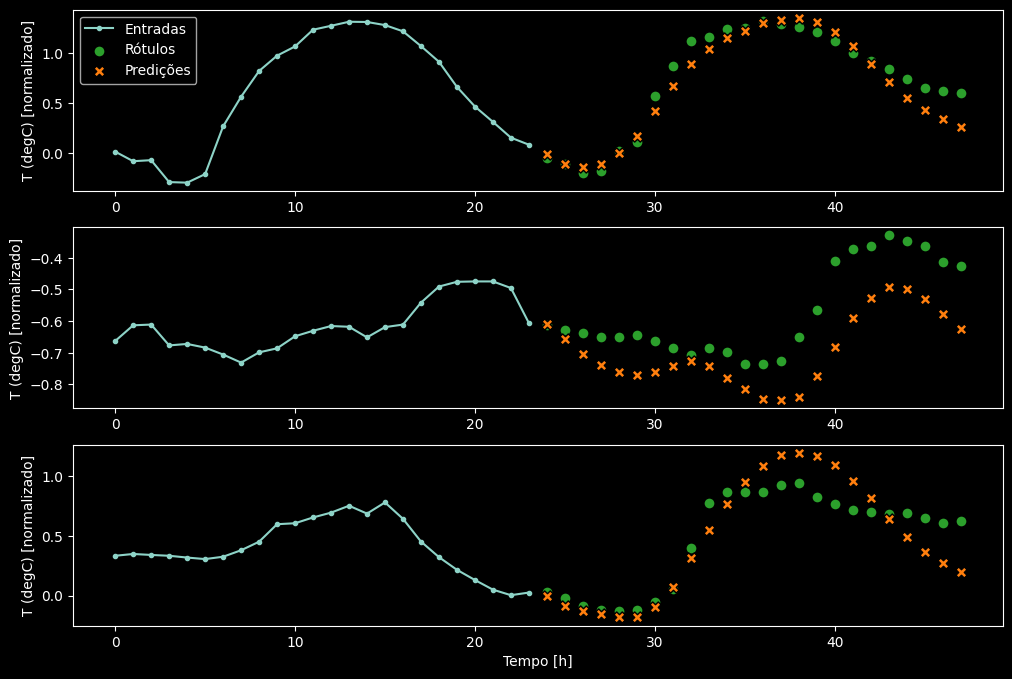

In [82]:
multi_dense_model = tf.keras.Sequential([
    # Pegue a última etapa de tempo.
    # Forma [lote, tempo, recursos] => [lote, 1, recursos]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Forma => [lote, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Formato => [lote, passos de saída*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Formato => [lote, passos de saída*features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

#### CNN

Um modelo convolucional faz previsões com base em um histórico de largura fixa, o que pode levar a um melhor desempenho do que o modelo denso, pois ele pode ver como as coisas estão mudando ao longo do tempo:

![Um modelo convolucional vê como as coisas mudam ao longo do tempo](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

  1/437 [..............................] - ETA: 16s - loss: 0.2243 - mean_absolute_error: 0.2874

437/437 [==============================] - 1s 1ms/step - loss: 0.2165 - mean_absolute_error: 0.2848


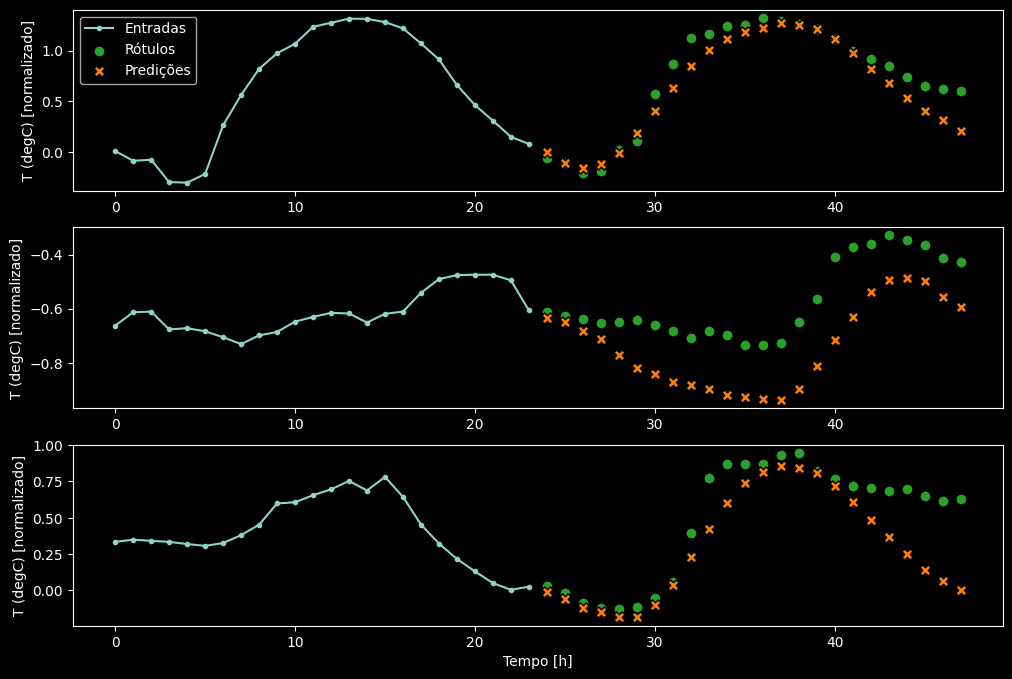

In [83]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Formato [lote, tempo, recursos] => [lote, CONV_WIDTH, recursos]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Formato => [lote, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [lote, 1, passos de saída*recursos]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, passos de saída, recursos]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

#### RNN

Um modelo recorrente pode aprender a usar um longo histórico de entradas, se isso for relevante para as previsões que o modelo está fazendo. Aqui, o modelo acumulará o estado interno por 24 horas, antes de fazer uma única previsão para as próximas 24 horas.

Nesse formato de disparo único, o LSTM só precisa produzir uma saída na última etapa de tempo, portanto, defina `return_sequences=False` em `tf.keras.layers.LSTM`.

![O LSTM acumula o estado na janela de entrada e faz uma única previsão para as próximas 24 horas](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


437/437 [==============================] - 1s 1ms/step - loss: 0.2144 - mean_absolute_error: 0.2845


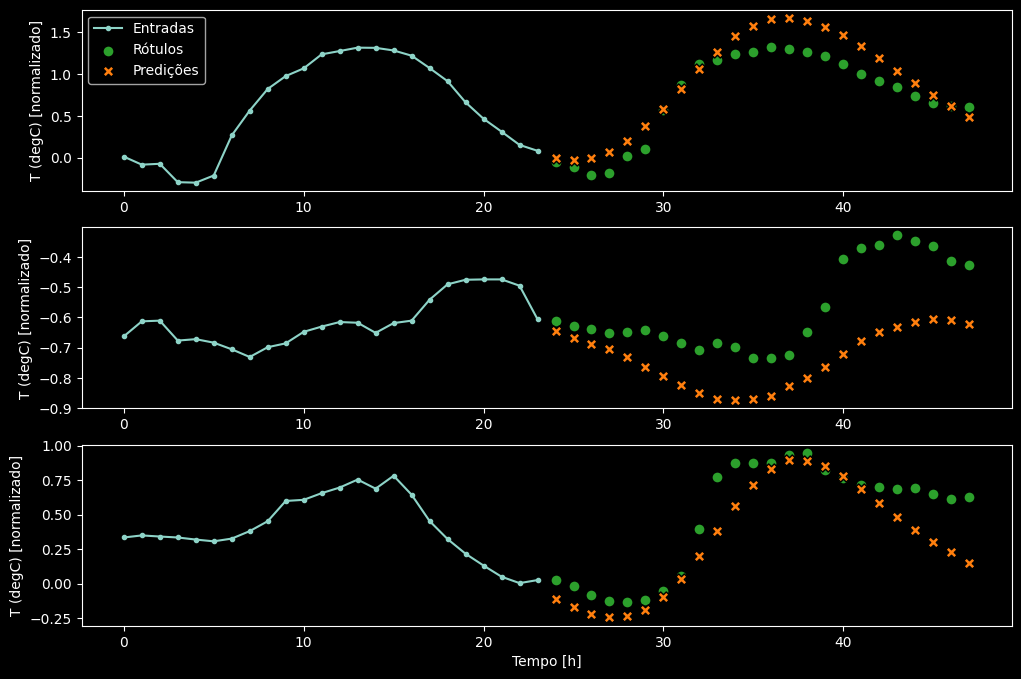

In [84]:
multi_lstm_model = tf.keras.Sequential([
    # Formato [lote, time, recursos] => [batch, lstm_units].
    # A adição de mais `lstm_units` apenas se sobrepõe mais rapidamente.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Formato => [lote, passos de saída*recursos].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Formato => [lote, passos de saída, recursos].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### Avançado: Modelo autorregressivo

Todos os modelos acima preveem toda a sequência de saída em uma única etapa.

Em alguns casos, pode ser útil para o modelo decompor essa previsão em etapas de tempo individuais. Em seguida, a saída de cada modelo pode ser realimentada em cada etapa e as previsões podem ser feitas com base na anterior, como no modelo  clássico <a href="https://arxiv.org/abs/1308.0850" class="external">Geração de sequências com redes neurais recorrentes</a>.

Uma vantagem clara desse estilo de modelo é que ele pode ser configurado para produzir uma saída com comprimento variável.


Uma vantagem clara desse estilo de modelo é que ele pode ser configurado para produzir resultados com comprimento variável.

Você poderia usar qualquer um dos modelos de saída múltipla de etapa única treinados na primeira parte deste tutorial e executá-los em um loop de feedback autorregressivo, mas aqui você se concentrará na criação de um modelo que tenha sido explicitamente treinado para fazer isso.

![Realimentar um modelo com sua entrada](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

Este tutorial constrói apenas um modelo RNN autorregressivo, mas esse padrão pode ser aplicado a qualquer modelo projetado para produzir uma única etapa de tempo.

O modelo terá a mesma forma básica que os modelos LSTM de etapa única anteriores: uma camada `tf.keras.layers.LSTM` seguida por uma camada `tf.keras.layers.Dense` que converte as saídas da camada `LSTM` em previsões de modelo.

Uma `tf.keras.layers.LSTM` é uma `tf.keras.layers.LSTMCell` envolvida no nível superior `tf.keras.layers.RNN` que gerencia o estado e os resultados da sequência para você (consulte o guia [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) para obter detalhes).

Nesse caso, o modelo precisa gerenciar manualmente as entradas para cada etapa, portanto, ele usa o `tf.keras.layers.LSTMCell` diretamente para a interface de nível inferior de etapa única de tempo.

In [85]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Também envolva o LSTMCell em um RNN para simplificar o método `warmup`.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [86]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

O primeiro método que esse modelo precisa é um método `warmup` para inicializar seu estado interno com base nas entradas. Uma vez treinado, esse estado capturará as partes relevantes do histórico de entrada. Isso é equivalente ao modelo `LSTM` de etapa única mencionado anteriormente:

In [87]:
def warmup(self, inputs):
  # inputs.shape => (lote, tempo, recursos)
  # x.shape => (lote, unidades lstm)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (lote, recursos)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Esse método retorna uma previsão de uma única etapa de tempo e o estado interno do `LSTM`:

In [88]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Com o estado do `RNN` e uma previsão inicial, você pode continuar a iterar o modelo alimentando as previsões em cada etapa como entrada.

A abordagem mais simples para coletar as previsões de saída é usar uma lista Python e um `tf.stack` após o loop.

Observação: o empilhamento de uma lista Python como essa só funciona com execução ansiosa, usando `Model.compile(..., run_eagerly=True)` para treinamento ou com uma saída de comprimento fixo. Para um comprimento de saída dinâmico, você precisaria usar um `tf.TensorArray` em vez de uma lista Python, e `tf.range` em vez do `range` Python.

In [89]:
def call(self, inputs, training=None):
  # Use um TensorArray para capturar saídas dinamicamente desenroladas.
  predictions = []
  # Inicializar o estado do LSTM.
  prediction, state = self.warmup(inputs)

  # Insira a primeira previsão.
  predictions.append(prediction)

  # Execute o restante das etapas de previsão.
  for n in range(1, self.out_steps):
    # Use a última previsão como entrada.
    x = prediction
    # Executar uma etapa do lstm.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Converta a saída do lstm em uma previsão.
    prediction = self.dense(x)
    # Adicione a previsão à saída.
    predictions.append(prediction)

  # predictions.shape => (tempo, lote, recursos)
  predictions = tf.stack(predictions)
  # predictions.shape => (lote, tempo, recursos)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Execute o teste desse modelo com as entradas de exemplo:

In [90]:
print('Forma de saída (lote, tempo, recursos):', feedback_model(multi_window.example[0]).shape)

Forma de saída (lote, tempo, recursos): (32, 24, 19)


Agora, treine o modelo:

437/437 [==============================] - 4s 9ms/step - loss: 0.2245 - mean_absolute_error: 0.3000


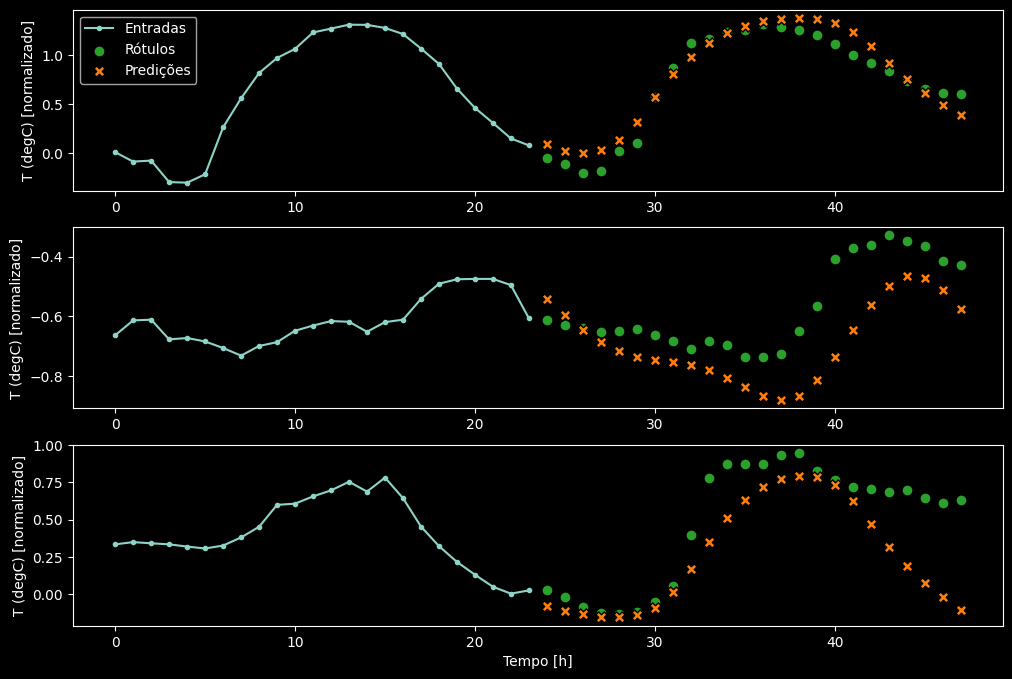

In [91]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

### Performance

Há claramente retornos decrescentes em função da complexidade do modelo nesse problema:

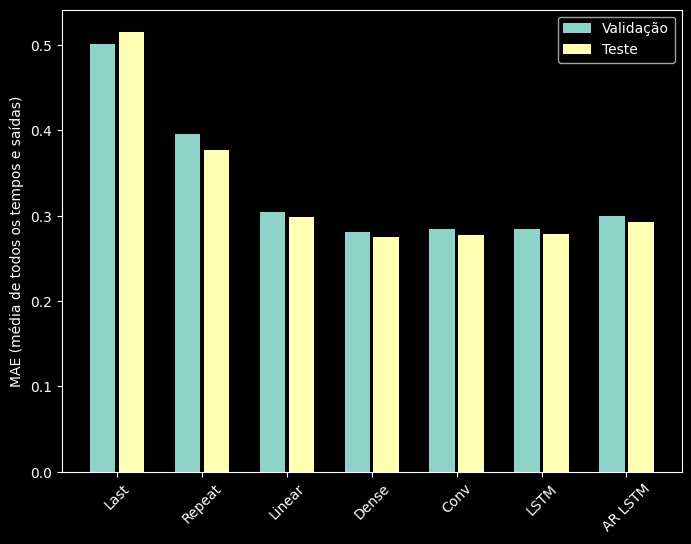

In [92]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validação')
plt.bar(x + 0.17, test_mae, width, label='Teste')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (média de todos os tempos e saídas)')
_ = plt.legend()

As métricas dos modelos de várias saídas na primeira metade deste tutorial mostram o desempenho médio de todos os recursos de saída. Esses desempenhos são semelhantes, mas também são calculados pela média das etapas de tempo de saída.

In [93]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[metric_name]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2982
Dense   : 0.2750
Conv    : 0.2771
LSTM    : 0.2788
AR LSTM : 0.2927


Os ganhos obtidos ao passar de um modelo denso para modelos convolucionais e recorrentes são de apenas alguns por cento (se houver), e o modelo autorregressivo teve um desempenho claramente pior. Portanto, essas abordagens mais complexas podem não valer a pena para **esse** problema, mas não há como saber sem tentar, e esses modelos podem ser úteis para **seu** problema.

## Próximos passos
Este tutorial foi uma rápida introdução à previsão de séries temporais usando o TensorFlow.

Para aprender mais consulte:

- Capítulo 15 de <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Capítulo 6 de <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lição 8 de <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, incluindo <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">cadernos de exercícios</a>.

Além disso, lembre-se de que você pode implementar qualquer <a href="https://otexts.com/fpp2/index.html" class="external">modelo clássico de série temporal</a> no TensorFlow - este tutorial se concentra apenas na funcionalidade integrada do TensorFlow.
